# XGBRegressor Evaluation

## read fold results and print as table

In [82]:
# load config file
import os
import yaml
import pandas as pd

config_path = os.path.join("..", "Config", "configs.yaml")

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
last_run_folder = config.get('last_run_folder', None)
output_folder = config.get('output_dir', None)

last_run_folder = os.path.join("..", output_folder, last_run_folder)

# load results.csv
df = pd.read_csv(os.path.join(last_run_folder, "results.csv"))

# print the results sorted by rmse
df_sorted = df.sort_values(by='test_rmse')
print(df_sorted.to_string(index=False))

# read the median_params.yaml
median_params_path = os.path.join(last_run_folder, "median_params.yaml")
with open(median_params_path, 'r') as file:
    median_params = yaml.safe_load(file)
    
# print the median parameters
print("\nMedian Parameters:")
for key, value in median_params.items():
    print(f"{key}: {value}")

# print the median results
median_results = df_sorted.iloc[len(df_sorted) // 2]
print("\nMedian Results:")
for key, value in median_results.items():
    print(f"{key}: {value}")



 fold   train_rmse    test_rmse   train_mae     test_mae  train_r2  test_r2
    4  4823.415939  7216.802013 1847.429309  2688.639703  0.999905 0.999366
    3  5394.637674  8132.197014 1925.371376  3368.124065  0.999878 0.999437
    2 26562.191463 26791.279962 6673.786673  7933.626076  0.996540 0.997274
    5 21179.473149 29806.915011 6491.432825  8581.322289  0.998045 0.994337
    1 22848.145222 71168.496301 8854.634546 22833.213701  0.996677 0.987164

Median Parameters:
l2_regularization: 0.65
learning_rate: 0.02
max_bins: 185
max_depth: 1
max_iter: 900

Median Results:
fold: 2.0
train_rmse: 26562.19146274011
test_rmse: 26791.27996222153
train_mae: 6673.786672798055
test_mae: 7933.626075787148
train_r2: 0.9965396203905718
test_r2: 0.997274129726628


we take the median, and perform a cv on the dataset and save the predicitons

## plot predictions

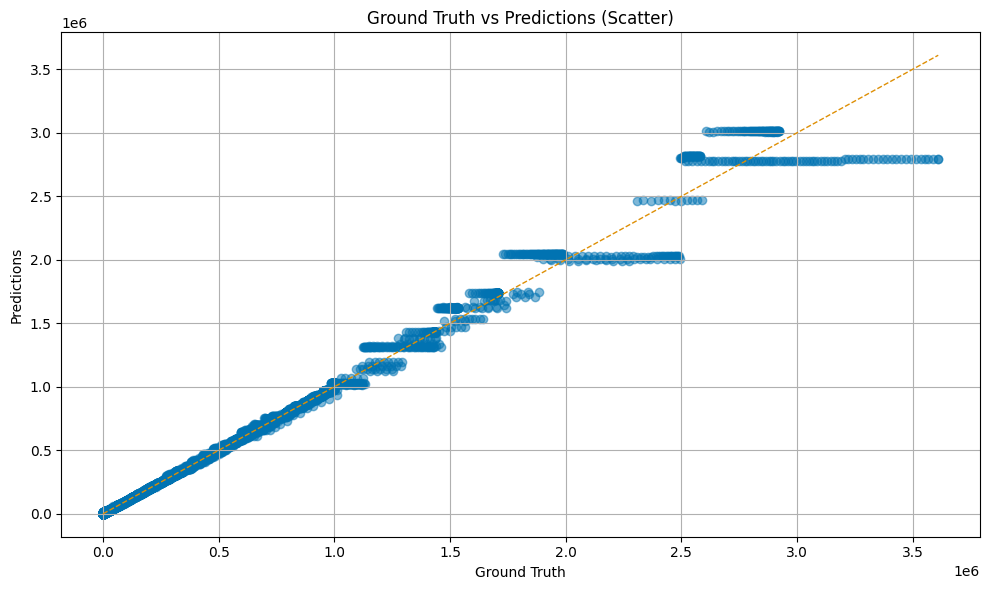

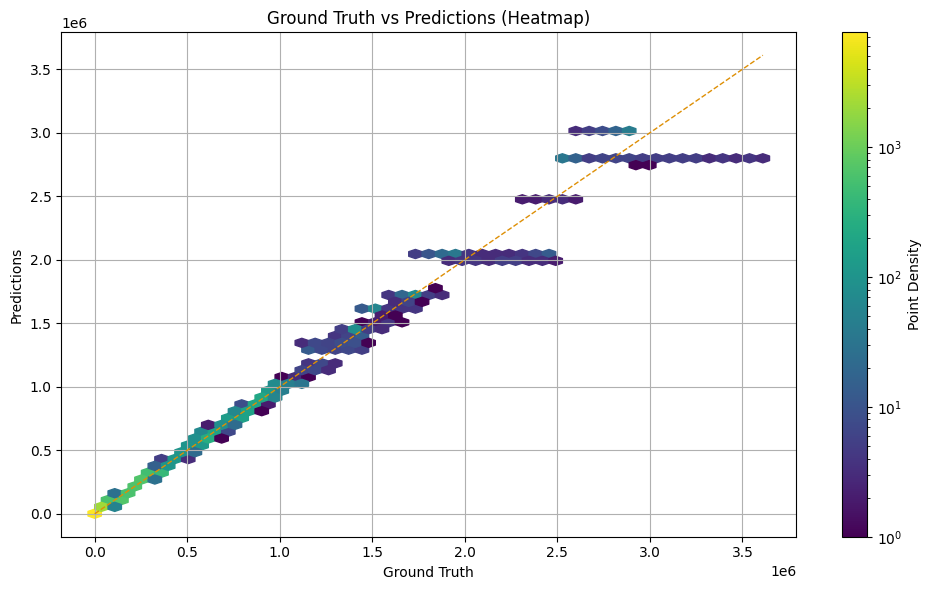

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

path_to_data = os.path.join(last_run_folder, "gt_vs_predictions.csv")

df = pd.read_csv(path_to_data)

# Use seaborn colorblind palette for scatter plot
palette = sns.color_palette("colorblind")
plt.figure(figsize=(10, 6))
plt.scatter(df["ground_truth"], df["predictions"], alpha=0.5, color=palette[0])
min_val = min(df["ground_truth"].min(), df["predictions"].min())
max_val = max(df["ground_truth"].max(), df["predictions"].max())
plt.plot([min_val, max_val], [min_val, max_val], color=palette[1], linestyle='--', linewidth=1)
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Ground Truth vs Predictions (Scatter)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2D Histogram (Heatmap) using a perceptually uniform, colorblind-friendly colormap
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    df["ground_truth"], df["predictions"],
    gridsize=50, cmap="viridis", bins='log'  # "viridis" is smooth and colorblind-friendly
)
plt.colorbar(hb, label='Point Density')
plt.plot([min_val, max_val], [min_val, max_val], color=palette[1], linestyle='--', linewidth=1)
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Ground Truth vs Predictions (Heatmap)")
plt.grid(True)
plt.tight_layout()
plt.show()

calculate RMSE and R^2

In [84]:
from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(df["ground_truth"], df["predictions"])
mae = (df["ground_truth"] - df["predictions"]).abs().mean()
r2 = r2_score(df["ground_truth"], df["predictions"])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2: {r2:.4f}")

RMSE: 40576.05
MAE: 9909.73
R^2: 0.9924


# Statistical analysis

In [85]:

# print percentage of gt = 0 from the whole dataset
percentage_gt_zero = (df["ground_truth"] == 0).mean() * 100
print(f"Percentage of ground truth values equal to 0: {percentage_gt_zero:.2f}%")

# mean and std of ground truth
mean_gt = df["ground_truth"].mean()
std_gt = df["ground_truth"].std()
print(f"Mean of ground truth: {mean_gt:.2f}")
print(f"Standard deviation of ground truth: {std_gt:.2f}")


Percentage of ground truth values equal to 0: 8.50%
Mean of ground truth: 251306.03
Standard deviation of ground truth: 464122.42


explain that mae is high but in comparison to the mean pred and std its not so bad

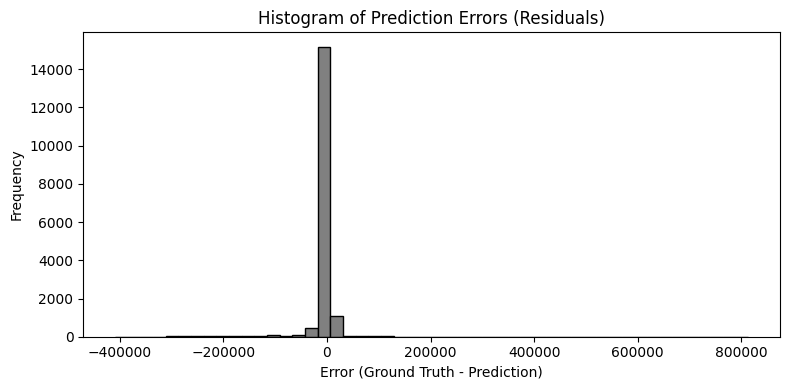

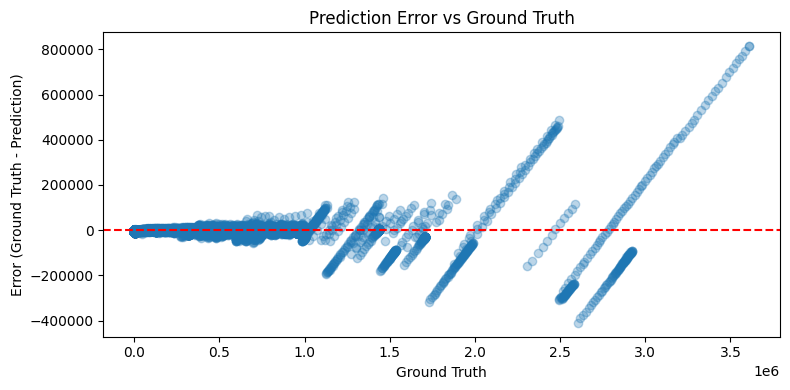

In [86]:
import numpy as np
# Calculate errors (residuals)
errors = df["ground_truth"] - df["predictions"]

# Plot histogram of errors
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=50, color='gray', edgecolor='black')
plt.title("Histogram of Prediction Errors (Residuals)")
plt.xlabel("Error (Ground Truth - Prediction)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
# Optional: Plot errors vs ground truth
plt.figure(figsize=(8, 4))
plt.scatter(df["ground_truth"], errors, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Error vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Error (Ground Truth - Prediction)")
plt.tight_layout()
plt.show()

## Limitations

Tree based models fit socioeconomical data.
Meaning using this model to forecast positive cases in countries or states where the socioeconomical status is significantly different may cause high errors, caused by the way the model works.
At each decision the model checks to see if a certain feature is higher or lower than a certain value, so for example if all the socioeconomical features a higher than all of the states this model was fitted, it will produce the same regression function

## SHAP

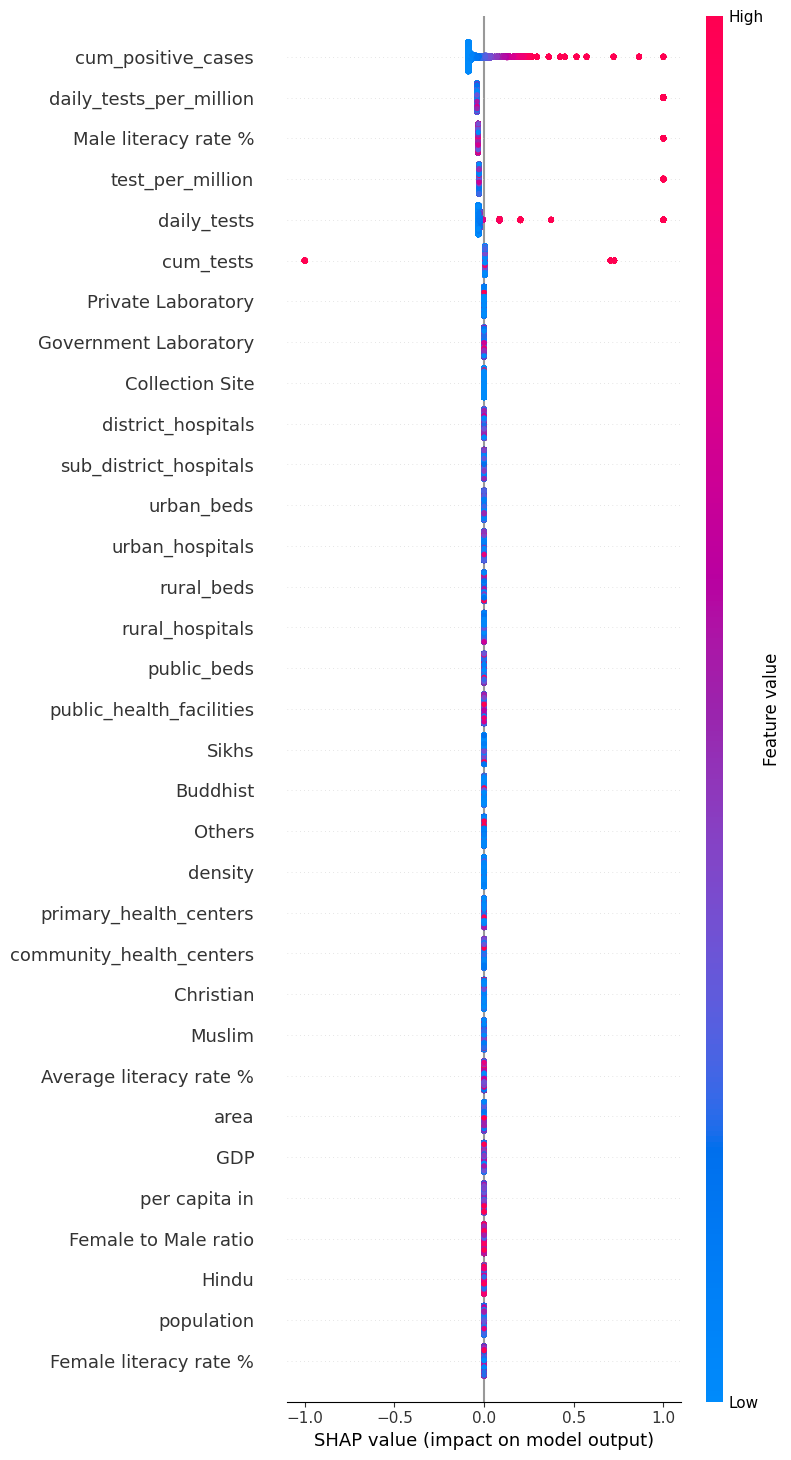

In [87]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import shap
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd
import os

train_data = pd.read_csv(os.path.join("..", config.get('data_path')))
X = train_data.drop(columns=['target', 'dates', 'state'])
y = train_data['target']

# Recreate and fit the model with the median parameters
model = HistGradientBoostingRegressor(**median_params)
model.fit(X, y)

# Create SHAP explainer and calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X, check_additivity=False)  # <-- disable additivity check

shap_vals = shap_values.values
# Normalize each feature's SHAP values by its max absolute value
shap_vals_norm = shap_vals / (np.abs(shap_vals).max(axis=0)+ 1e-10)
shap.summary_plot(shap_vals_norm, X, feature_names=X.columns, max_display=X.shape[1])


exp